# Pylazybam example useage

Matthew Wakefield

<small>The Walter and Eliza Hall Institute and The University of Melbourne</small>

This example file is intended to give a flavour of the potential usages of pylazybam. As a library intened for interactive use in notebooks and bespoke scripts its intentionally very open ended and flexable.

First you will need to install pylazybam following the instructions in the readme. There are no dependencies, so this should be easy even on Windows and ARM based linux, although you will have issues with anything other than trivial BAM files on a Raspberry Pi.

In [1]:
from pylazybam import bam
import gzip

We import as `bam` as it gives an easy to type, short, safe and descriptive namespace.
You can get help on pylazybam functions by using `help()` or in a notebook prefacing with a `?`

In [2]:
?bam.FileReader

Init signature: bam.FileReader(ubam: <class 'BinaryIO'>)
Docstring:     
A Pure Python Lazy Bam Parser Class

Parameters
----------
    ubam : BinaryIO
        An binary (bytes) file or stream containing a valid uncompressed
        bam file conforming to the specification.

Yields
------
    align : bytes
        A byte string of a bam alignment entry in raw binary format

Attributes
----------
    header : str
        The ASCII representation of the header

    index_to_ref : Dict[int:str]
        A dictionary mapping bam reference numeric identifiers to names

    raw_header : bytes
        The raw bytestring representing the bam header

    raw_refs : bytes
        The raw bytestring representing the reference sequences

    refs : Dict[str:int]
        A dictionary of reference_name keys with reference_length

    ref_to_index : Dict[str:int]
        A dictionary mapping reference names to the bam numeric identifier

    sort_order : str
        The value of the SO field indicatin

We are using data generated by the NYU genome centre from one of the well know genome in a bottle references. This case has been sequenced to high depth, and mapped against a GRCh38 reference with decoys and ALTs
It can be downloaded from `lftp ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR323/ERR3239484/NA12778.final.cram`
The file we are using has had some manipulations done on it with `samtools view` but the exact manipulations have been lost to the mists of time and advancing years of the operator. Time for some bioinfosleuthing<sup>(tm)</sup> Lets open the file up and have a look at what we can see.

In [3]:
NA12778 = bam.FileReader(gzip.open('Genomes/NA12778_GRCh38_HLA_namesorted.bam'))
for headerline in NA12778.header.split('\n'):
    if headerline[:3] == '@PG':
        print(headerline)

@PG	ID:MarkDuplicates	VN:2.4.1(7c4d36e011df1aec4689b51efcada44e92d1817f_1464389670)	CL:picard.sam.markduplicates.MarkDuplicates INPUT=[/data/analysis/DarnellR/Project_CCDG_13607_B01_GRM_WGS/Sample_NA12778/analysis/NA12778.merged.bam] OUTPUT=/scratch/3ad0b0f54a6c428eb90eea99b52683dd/NA12778.bam METRICS_FILE=/data/analysis/DarnellR/Project_CCDG_13607_B01_GRM_WGS/Sample_NA12778/qc/NA12778.dedup.metrics VALIDATION_STRINGENCY=SILENT COMPRESSION_LEVEL=0 MAX_RECORDS_IN_RAM=2000000    MAX_SEQUENCES_FOR_DISK_READ_ENDS_MAP=50000 MAX_FILE_HANDLES_FOR_READ_ENDS_MAP=8000 SORTING_COLLECTION_SIZE_RATIO=0.25 REMOVE_SEQUENCING_DUPLICATES=false TAGGING_POLICY=DontTag REMOVE_DUPLICATES=false ASSUME_SORTED=false DUPLICATE_SCORING_STRATEGY=SUM_OF_BASE_QUALITIES PROGRAM_RECORD_ID=MarkDuplicates PROGRAM_GROUP_NAME=MarkDuplicates READ_NAME_REGEX=<optimized capture of last three ':' separated fields as numeric values> OPTICAL_DUPLICATE_PIXEL_DISTANCE=100 VERBOSITY=INFO QUIET=false CREATE_INDEX=false CREATE_MD5

Ok so we can see a lot of programs have operated on this file, but there are no entries for samtools so we dont know the basis for the subsetting. Lets see if we can work it out.

In [4]:
from collections import Counter
id_counts = Counter()
for align in NA12778:
    id_counts[bam.get_ref_index(align)] += 1
print(id_counts)

Counter({5: 1206714, 3343: 1855, 3326: 391, 3330: 327, 3309: 289, 3307: 284, 3328: 219, 3308: 204, 3329: 179, 3327: 179, 3170: 41, 3164: 38, 3165: 38, 3171: 37, 3167: 36, 3035: 35, 3034: 32, 3169: 31, 3038: 29, 3172: 26, 2877: 24, 3177: 24, 3190: 24, 2861: 24, 3041: 23, 2855: 23, 3166: 23, 2867: 22, 3033: 22, 3188: 21, 3189: 21, 3192: 21, 2863: 21, 2873: 20, 2853: 20, 2875: 20, 3184: 20, 3347: 20, 3168: 20, 2870: 20, 3173: 19, 2866: 19, 2852: 19, 2857: 19, 2871: 19, 3037: 19, 3174: 19, 3183: 18, 2884: 18, 3181: 18, 3070: 18, 3071: 18, 2879: 18, 2856: 18, 3306: 18, 2862: 18, 2885: 18, 3179: 17, 3074: 17, 3191: 17, 2859: 17, 3077: 17, 2878: 17, 2864: 17, 3178: 17, 2869: 16, 2860: 16, 3075: 16, 3079: 16, 3180: 15, 2970: 15, 3080: 15, 2872: 15, 2882: 15, 2956: 14, 3186: 14, 2881: 14, 2876: 14, 3039: 13, 2854: 13, 2865: 13, 2868: 13, 3176: 13, 2883: 13, 2874: 13, 3076: 12, 2967: 12, 3185: 12, 3072: 12, 3107: 12, 3353: 11, 2858: 11, 2962: 11, 3187: 11, 3102: 10, 3082: 10, 2968: 10, 3106: 10,

We have over 1.2M reads from index 5, so that must be the chromosome that was specified in the samtools view region. We can look up its name:

In [5]:
NA12778.index_to_ref[5]

'chr6'

Chromosome 6 makes sense at it is MHC related. Lets see if we can work out what the start and end of the selected regions were.

In [6]:
with bam.FileReader(gzip.open('Genomes/NA12778_GRCh38_HLA_namesorted.bam')) as NA12778:
    pos = []
    for align in NA12778:
        if bam.get_ref_index(align) == 5:
            pos.append(bam.get_pos(align))
    print(f'Reads from {NA12778.index_to_ref[5]} start at {min(pos)} and end at {max(pos)}')

Reads from chr6 start at 28509971 and end at 33480576


Given that reads overlapping the region and their pairs will be included in the output, it looks like samtools view - chr:28510000-33480000 is the most likely command used to generate the file, likely converting from CRAM to BAM in the process. Now lets check if it has been sorted

In [7]:
NA12778 = bam.FileReader(gzip.open('Genomes/NA12778_GRCh38_HLA_namesorted.bam'))
print(NA12778.sort_order)

queryname


So just like it suggest in the filename this BAM has reads that map to the HLA region on chromosome 6 in a namesorted order. This is just what we need for the next step which is selecting those reads that have mappings on the HLA alt chromosomes, and writing them to a new file.

To do this we will set up a bam.FileReader and a bam.FileWriter. We will copy across the header information for the new file from the original, and we will add an @PG line to indicate what we have done. It's a bit hard to make it completely reproducable with an ad hoc script, but we can show we did something and indicate our intent.

In [8]:
NA12778 = bam.FileReader(gzip.open('Genomes/NA12778_GRCh38_HLA_namesorted.bam'))
NA12778_any_HLA_hits = bam.FileWriter('Genomes/NA12778_any_HLA_hits.bam')
NA12778_any_HLA_hits.raw_header = NA12778.raw_header
NA12778_any_HLA_hits.raw_refs = NA12778.raw_refs
NA12778_any_HLA_hits.update_header(id = 'pylazybam_any_HLA',
                                   program = 'pylazybam',
                                   version = '0.1.0',
                                   description = "all alignments for reads where any alignment maps to a HLA alt contig")
NA12778_any_HLA_hits.write_header()

We have a file to read from, a file to write to, and all we need now are some functions to manipulate the reads along the way. The first function is to get all the alignments that belong to a given read pair at once.

In [9]:
def get_alignment_batches(in_bam):
    previous_name = None
    alignbatch = []
    for align in in_bam:
        name = bam.get_raw_read_name(align, bam.get_len_read_name(align))
        if previous_name and name != previous_name:
            yield alignbatch
            alignbatch = []
        alignbatch.append(align)
        previous_name = name
    if alignbatch:
        yield alignbatch

Now we need a function that iterates through the batches of alignments and make a decision on each of the alignments. In our case it is going to find alignment batches where any alignment has a reference assignment that we are interested in.

In [10]:
def any_align_maps_to_ref(in_bam, refs = [0,]):
    # Iterate through groups of alignments from the same read
    for alignbatch in get_alignment_batches(in_bam):
        # Iterate through alignments from the same read
        for align in alignbatch:
            if bam.get_ref_index(align) in refs:
                yield alignbatch
                break

Ok so what alignment ids are we interested in? They are not human friendly so we will need to look them up in the `ref_to_index` dictionary on the `FileReader`

In [11]:
HLA_refnames = [x for x in NA12778.ref_to_index.keys() if 'HLA' in x]            
HLA_refids = [NA12778.ref_to_index[x] for x in HLA_refnames]

So now that we have all the pieces we need lets collect out the reads we are interested in looking at. We are going to use timeit so we have an idea of what the perfomance is like.

In [12]:
%%timeit -n 1 -r 1
for alignbatch in any_align_maps_to_ref(NA12778, HLA_refids):
    for align in alignbatch:
        NA12778_any_HLA_hits.write(align)

21 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
#we will close the file to ensure the end of file marker is correctly written
NA12778_any_HLA_hits.close()

That took 20s on a seven year old MacBook Pro for 1.2M reads. Reasonable for interactive use. More typical files of 100M reads you will want to go to lunch. Something like the original 700M read file will take 3-4h.

## Plotting AS vs XS scores

Now that we have the reads we are interested in one file we can ask a slightly more intersting question - what does the distribution of AS (reported primary alignment) and XS (next best alignment) scores look like for these reads.

In [14]:
NA12778_any_HLA_hits = bam.FileReader(gzip.open('Genomes/NA12778_any_HLA_hits.bam'))

In [15]:
primary_AS_XS = []
for align in NA12778_any_HLA_hits:
    if not bam.is_flag(align, bam.FLAGS['secondary']):
        primary_AS_XS.append((bam.get_AS(align,no_tag=0),bam.get_XS(align,no_tag=0)))

In [16]:
print(primary_AS_XS[:5], len(primary_AS_XS))

[(0, 0), (0, 0), (0, 0), (150, 150), (150, 150)] 10079


In [17]:
from matplotlib.pyplot import hexbin, figure

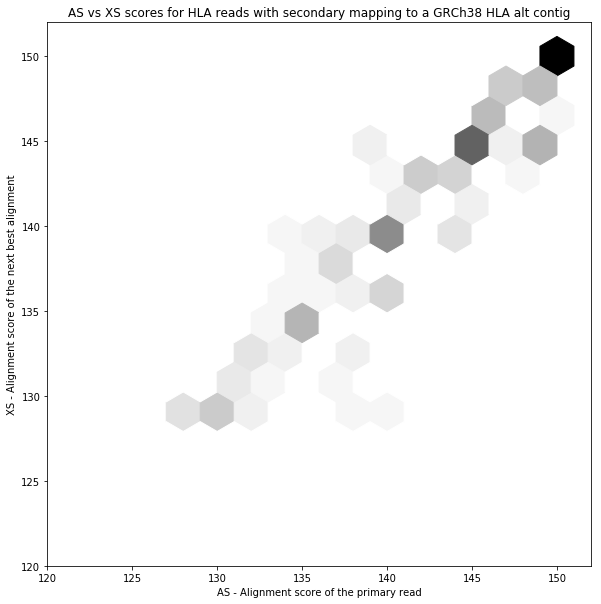

In [18]:
fig = figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, aspect=1)
ax.set_xlim(120,152)
ax.set_ylim(120,152)
ax.set_ylabel("XS - Alignment score of the next best alignment")
ax.set_xlabel("AS - Alignment score of the primary read")
ax.set_title("AS vs XS scores for HLA reads with secondary mapping to a GRCh38 HLA alt contig")
hexbin(x=[x[0] for x in primary_AS_XS],y=[y[1] for y in primary_AS_XS], gridsize=75, bins='log', cmap='Greys')

This is a simple example, but by combining the alignbatch approach above more complex examples that look at relationships between different alignments of a read pair and/or factors like the presence and type of variants can easily be constructed.

## Outputing reads as fastq
Sometimes it is useful to output a subset of reads for further analysis, and occasionally you will want to do this in fastq format

In [19]:
test = b'\xcd\x01\x00\x00\xf5\x0c\x00\x00^\x08\x00\x00\'\tI\x12\x02\x00s\x08\x96\x00\x00\x00\x0b\x00\x00\x00h\x88\xeb\x04\xd0\x01\x00\x00A00132:55:HCKWTDSXX:1:1102:27263:27759\x00\xf0\x01\x00\x00t\x07\x00\x00\x14\x11\x14\x11\x14\x11\x11\x14A\x14A\x14A\x14!"A\x14A\x14B\x12"\x12A\x14A\x14B\x14A\x11\x14!A!\x81!D(A\x11HA\x14A\x18A\x11\x12\x14(\x18\x82!\x84!\x11\x84H\x11"\x11\x11\x81!B\x11AHA\x88\x12\x12\x88\x1e\x1e\x1e\x1e\x1e\n\x1e\n\x1e\n\n\x1e\n\n\x1e\n\x1e\x1e\x1e\x1e\x1e\n\x1e\n\n\n\x14\x14\n\n\n\x04\n\x1e\x1e\n\n\x1e\x14\n\x14\n\n\n\n\n\n\x04\n\x1e\x1e\n\n\x1e\x14\n\x1e\n\x1e\n\n\x1e\x1e\x1e\x14\x1e\n\x1e\n\n\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\n\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\n\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\n\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\n\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x14\x1eSAZchr12,82544431,+,102M48S,60,3;\x00XAZchr12,+82544561,122S28M,0;\x00MCZ150M\x00PGZMarkDuplicates\x00ASc\x1eXSc\x1cMDZ0G30\x00NMI\x01\x00\x00\x00RGZNA12778_CTCACCAA-CTAGGCAA_HCKWTDSXX_L001\x00'

def align_to_fastq(align):
    readname_length = bam.get_len_read_name(align)
    number_cigar_operations = bam.get_number_cigar_operations(align)
    sequence_length = bam.get_len_sequence(align)
    readname = bam.get_read_name(align, readname_length)
    sequence = bam.decode_sequence(bam.get_raw_sequence(align, readname_length, number_cigar_operations, sequence_length))
    qual = bam.decode_base_qual(bam.get_raw_base_qual(align, readname_length, number_cigar_operations, sequence_length))
    return f"@{readname}\n{sequence}\n{'+'}\n{qual}\n"


print(align_to_fastq(test))

@A00132:55:HCKWTDSXX:1:1102:27263:27759
AGAAAGAAAGAAAAAGGAAGGAAGGAAGCACCGAAGGAAGGCACCCACGAAGGAAGGCAGGAAAAGCAGACATACAGGCTGAAAGTGAAGGAATGAAAACAGCTATTCCATGCAAATGGTAACCAAAATACAGCAAGAGTGATTACACTT
+
?????+?+?++?++?+?????+?+++55+++%+??++?5+5++++++%+??++?5+?+?++???5?+?++????????????????????+??????????????+?????????+????????????+???????????????????5?



In [20]:
fastqf = open('NA12778_any_HLA_hits.R1.fastq.gz','w')
fastqr = open('NA12778_any_HLA_hits.R2.fastq.gz','w')

In [21]:
NA12778_any_HLA_hits = bam.FileReader(gzip.open('Genomes/NA12778_any_HLA_hits.bam'))
for align in NA12778_any_HLA_hits:
    if not bam.is_flag(align, bam.FLAGS['secondary']):
        if bam.is_flag(align, bam.FLAGS['forward']):
            fastqf.write(align_to_fastq(align))
        else:
            fastqr.write(align_to_fastq(align))
fastqf.close()
fastqr.close()

### your uses
If you have an interesting use of pylazybam feel free to send a pull request against the readme and I will add it to a list of contributed example scripts